In [1]:
from sqlalchemy import create_engine
import pandas as pd
from pandas.io import sql
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 

In [2]:
def establish_conection(password, databasename = 'ConservatorDatabase', username = 'sa', hostname = 'localhost', port = '1433') :
    '''
    Establishes sqlalchemy connection to a mssql database

    Need to give it a password; default user = sa, port = 1433, hostname = localhost, databasename = ConservatorDatabase
    username, password, hostname, port, databasename

    returns engine
    '''
    engine_string = 'mssql+pymssql://' + username + ':' + password + '@' + hostname + ':' + port + '/' + databasename

    return create_engine(engine_string)

def read_sql_table(tablename):
    '''
    tablename as a string
    read table in pandas, return query as a dataframe
    '''

    engine = establish_conection(password='gr@vityI13') 
    # This is a local password, on my laptop; would need to modify for 
    # other users, computers.

    return sql.read_sql_table(tablename, engine)

In [3]:
df = read_sql_table('IncomeExpenseTransactions')
df2 = read_sql_table('TransactionCategories')

In [5]:
df. columns

Index([u'IncomeExpenseReportId', u'CaseFileReportId', u'AccountId',
       u'Description', u'Amount', u'TransactionDate', u'IsIncome',
       u'IsExpense', u'TransactionCategoryId', u'CreateDate', u'CreateUserId',
       u'LastModDate', u'LastModUserId', u'CourtOrderTransaction',
       u'TransactionPaymentTypeId', u'CheckNumber', u'SoldPropertyId',
       u'MortgagedRealEstateReportId', u'BoughtPropertyType', u'Amended',
       u'BoughtPropertyDescription', u'DateMovedFromCareFacility',
       u'RealEstateIncludesPropertyTaxes', u'RealEstatePropertyTaxesAmount',
       u'RealEstateIncludesPropertyInsurance',
       u'RealEstatePropertyInsuranceAmount',
       u'ProtectedPersonLivesAtCareFacility', u'TrustName'],
      dtype='object')

## Removing unnecessary data and renaming columns for ease of use

In [6]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

column_rename = {'IncomeExpenseReportId': 'IncExpId', 'CaseFileReportId': 'CasFil',
                 'TransactionDate': 'TranDt',
                 'TransactionCategoryId': 'TranCat', 'CourtOrderTransaction': 'CourtOrdTran',
                 'ProtectedPersonLivesAtCareFacility': 'CarFac'}

df.rename(columns=column_rename, inplace=True)

df['Expense'] = df['IsExpense'].astype(int)
df['CarFac'] = df['CarFac'].astype(int)
df['CourtOrdTran'] = df['CourtOrdTran'].astype(int)

del df['CreateUserId']
del df['LastModUserId']
del df['LastModDate']
del df['CheckNumber']
del df['Amended']
del df['TrustName']
del df['IsIncome']
del df['IsExpense']

In [7]:
d_tran = {}

trans_cat = df2['TransactionCategoryId'].unique()
for i in xrange(len(trans_cat)):
    d_tran[df2.iloc[i]['TransactionCategoryId']] = df2.iloc[i]['Description']

df['TranDescr'] = df['TranCat'].map(d_tran)


#### Removing some expense categories, as they do not add to fraud.

    * 245 - Transfer to another coount.
    * 249 - CAAP Audit Fee 
    * 228 - 

In [8]:
income_categories = df2[(df2['CategoryTypeId']==2) & (df2['TransactionCategoryId']!=245) & 
                        (df2['TransactionCategoryId']!=228) & 
                        (df2['TransactionCategoryId']!=249 )]['TransactionCategoryId'].tolist()

In [9]:
columns_to_keep = ['IncExpId', 'CasFil', 'Expense', 'Amount', 'TranDt', 'TranCat', 'TranDescr', 'CourtOrdTran', 'CarFac' ]
df = df[(df['TranCat'].isin(income_categories)) & (df['TranDt']> datetime.date(year=2010,month=1,day=1))
        & (df['TranDt']<datetime.date(2016, 1, 1))][columns_to_keep]

df['NumDays'] = (df['TranDt'] - df['TranDt'].min())/ np.timedelta64(1,'D')


df.head()

,IncExpId,CasFil,Expense,Amount,TranDt,TranCat,TranDescr,CourtOrdTran,CarFac,NumDays
0,4673,4815,1,1250.0,2014-04-15,185,Care Facility,0,1,1562.0
1,4674,4815,1,104.0,2014-04-15,214,Personal Needs,0,0,1562.0
2,4675,4815,1,352.0,2014-04-15,240,Medical - Prescriptions,0,0,1562.0
3,4676,4816,1,500.0,2014-04-15,214,Personal Needs,0,0,1562.0
4,4677,4820,1,456.0,2014-04-15,239,Rent,0,0,1562.0


In [28]:
len(df['CasFil'].unique())

9125

In [10]:
df.to_csv('expense.csv')

In [11]:
duration = df.groupby(by='CasFil')['NumDays'].max() - df.groupby(by='CasFil')['NumDays'].min()
NoCount = df.groupby(by='CasFil')['Amount'].count()
Total = df.groupby(by='CasFil')['Amount'].sum()

raw = {'Duration': list(duration), 'NumDataPts' : list(NoCount), 'Total' : Total}
explore = pd.DataFrame(raw, columns = ['Duration', 'NumDataPts',  'Total'], index=NoCount.index)
explore.reset_index(level=0, inplace=True)

In [12]:
df2[(df2['CategoryTypeId']==2) &(df2['TransactionCategoryId']!=245) & 
                        (df2['TransactionCategoryId']!=228) & 
                        (df2['TransactionCategoryId']!=249 )][['TransactionCategoryId', 'Description']].to_csv('expense_description.csv')

### Collecting expenses of similar category together.

This collapses 57 types of expenses into 23 categories

In [13]:
expense_collect= dict.fromkeys(['Automobile - Gasoline', 'Automobile - Maintenance', 'Automobile - Payment', 
                                'Insurance - Auto'], 'Automobile')
expense_collect.update(dict.fromkeys(['Fees - Accountant', 'Taxes - Federal', 'Taxes - State', 'Taxes - Other Taxes'], 'Income Tax'))
expense_collect.update(dict.fromkeys(['Taxes - Real Estate', 'Household - Laundry/Dry Cleaning', 'Rent', 'Mortgage',
                                      'Household - Maintenance/Repairs', 'Household - Other Household', 'Insurance - Home/Renter', 
                                      'Fees - Realtor/Appraiser'], 'Household'))
expense_collect.update(dict.fromkeys(['Personal Needs', 'Miscellaneous Expense'], 'Personal Misc'))
expense_collect.update(dict.fromkeys(['Utilities - Telephone/Internet/Cable', 'Utilities - Garbage', 
                                      'Utilities - Gas & Electric', 'Utilities - Water/Sewer'], 'Utilities'))
expense_collect.update(dict.fromkeys(['Hobby', 'Entertainment', 'Pet Care'], 'Hobby'))
expense_collect.update(dict.fromkeys(['Insurance - Medical', 'Medical - Ambulance/Transport', 
                                      'Medical - Dental', 'Medical - Doctor/Hospital', 'Medical: Equipment', 
                                      'Medical - Prescriptions'], 'Medical'))
expense_collect.update(dict.fromkeys(['Transportation', 'Travel'], 'Travel'))
expense_collect.update(dict.fromkeys(['Fees - Court', 'Fees - Attorney'], 'Court'))
expense_collect.update(dict.fromkeys(['Bank Service Charges', 'Bond Premium', 
                                      'Debt - Interest', 'Fees - Late'], 'Banking'))
expense_collect.update(dict.fromkeys(['Services - Cleaning', 'Services - Personal Care', 'Subscriptions & Dues'], 'Services'))
expense_collect.update(dict.fromkeys(['Food - Groceries', 'Food - Dining Out'], 'Food'))
expense_collect.update(dict.fromkeys(['Charitable Donation','Gifts Given'], 'Charity Gifts'))

expense_collect.update(dict.fromkeys([]))
expense_collect['Care Facility'] = 'Care Facility'
expense_collect['Fees - Guardian/Conservator'] = 'Fees - Guardian or Conservator'

expense_collect['Insurance - Other Insurance'] = 'Insurance - Other Insurance'
expense_collect['Clothing'] = 'Clothing'
expense_collect['Fees - Other Fees'] = 'Fees - Other Fees'
expense_collect['Asset Depreciation'] = 'Asset Depreciation'
expense_collect['Personal Property - Purchase'] = 'Personal Property - Purchase'
expense_collect['Support Payments'] = 'Support Payments'
expense_collect['Funeral'] = 'Funeral'
expense_collect['Education'] = 'Education'

In [59]:
df['TranCatColl'] = df['TranDescr'].map(expense_collect)
df.tail()

,IncExpId,CasFil,Expense,Amount,TranDt,TranCat,TranDescr,CourtOrdTran,CarFac,NumDays,TranCatColl
1159607,1267338,22208,1,7.36,2014-10-27,197,Food - Groceries,0,0,1757.0,Food
1159608,1267339,22208,1,10.84,2014-10-22,197,Food - Groceries,0,0,1752.0,Food
1159609,1267340,22208,1,26.56,2014-12-08,197,Food - Groceries,0,0,1799.0,Food
1159610,1267341,22208,1,27.16,2014-10-29,197,Food - Groceries,0,0,1759.0,Food
1159612,1267343,22208,1,44.25,2014-12-13,197,Food - Groceries,0,0,1804.0,Food


In [16]:
def counting_neighbours(cat, df):
    '''
    
    This function works on one category of expenses at a time. It takes in a 
    dataframe that has CaseFileID, expense category, expense amount and for each 
    CaseFileID the duration for which the person is on the database.
    
    It outputs a CSV file written using NumPy. It has one line for each person on 
    the database. The columns are-
    
    1. CaseFile ID
    2. Number of transactions in that given category, normlized to the duration for 
    which the person is on the Database.
    3. Dollar amount spent in that category, normalized to the total amount spend for
    that person, in that given category.
    4. Number of neighbours within median distance between the points.
    5. Rank - Number of neighbours/Maximum number of neighbours in a given category
    Bigger the rank, more normal the number.
    
    '''
    
    
    average = df[df['TranCatColl']==cat].groupby('CasFil')['Amount'].mean()
    count = df[df['TranCatColl']==cat].groupby('CasFil')['Amount'].count()
    dura = df[df['TranCatColl']==cat].groupby('CasFil')['NumDays'].mean()
    count = np.array(count/dura)
    casfil = np.array(dura.index)
    aver = np.array(average.values)
    norm_aver = aver * np.max(count) / np.max(aver)
    
    if np.sum(dura.index == aver.index) != 1:
        print 'Alarm, indeces do not match for ', cat
        break

    arr = np.stack((casfil, count, norm_aver), axis=1)

    dist = []
    length = len(arr)
    for i in xrange(length):
        for j in xrange(i+1, length):
            dist.append(np.linalg.norm(arr[i, 1:] - arr[j, 1:]))

    med = np.median(dist)

    neighbours = []
    for i in xrange(length):
        dist = []
        for j in xrange(length):
            if i != j:
                dist.append(np.linalg.norm(arr[i, 1:] - arr[j, 1:]))
        dist = np.array(dist)
        neighbours.append(np.sum(dist < med))
    neighbours = np.array(neighbours)
    rank = neighbours / np.max(neighbours)

    arr = np.stack((casfil, count, aver, neighbours, rank), axis =1)

    filename = cat + str('.csv')
    np.savetxt(filename, arr, delimiter=',')

In [18]:
collected_categories = df['TranCatColl'].unique()

In [ ]:
for cat in collected_categories:
    counting_neighbours(cat)

In [246]:
def read_csv_to_df(csv_name):
    '''
    pd.read_csv with desired column names and header = None
    '''
    
    
    df1 = pd.read_csv(csv_name, header=None, 
                 names = ['CasFil', 'Norm Count', 'Average Expense', 'Neighbours'])
    df1['Rank'] = 1 - df1['Neighbours'] / df1['Neighbours'].max()
    
    return df1

df1 = read_csv_to_df((collected_categories[0] + str('.csv')))


for cat in collected_categories[1:]:
    df2 = read_csv_to_df(cat + str('.csv'))
    df1 = pd.merge(df1, df2, how='outer', left_on='CasFil', right_on='CasFil', sort=True)
    df1.fillna(0, inplace=True)
    col_to_keep = ['CasFil', 'Rank_x', 'Rank_y']
    df1 = df1[col_to_keep]
    df1['Rank'] = df1['Rank_x'] + df1['Rank_y']
    df1 = df1[['CasFil', 'Rank']]
    

df1['CasFil'] =df1['CasFil'].astype(int)

In [247]:
average = df.groupby('CasFil')['Amount'].sum()
count = df.groupby('CasFil')['Amount'].count()
dura = df.groupby('CasFil')['NumDays'].mean()
# count = count/dura

count = count.to_frame(name = 'CountPerDay')
count['AverageExpense'] = average
count['Duration'] = dura
df1 = df1.join(count, how='inner', on='CasFil')
df1['Rank'] = df1['Rank']/df1['Rank'].max()
df1.to_csv('rank.csv')

In [248]:
df1['Rank'].min(), df1['Rank'].max(), df1['Rank'].median()

(0.0, 1.0, 0.14178132338691318)

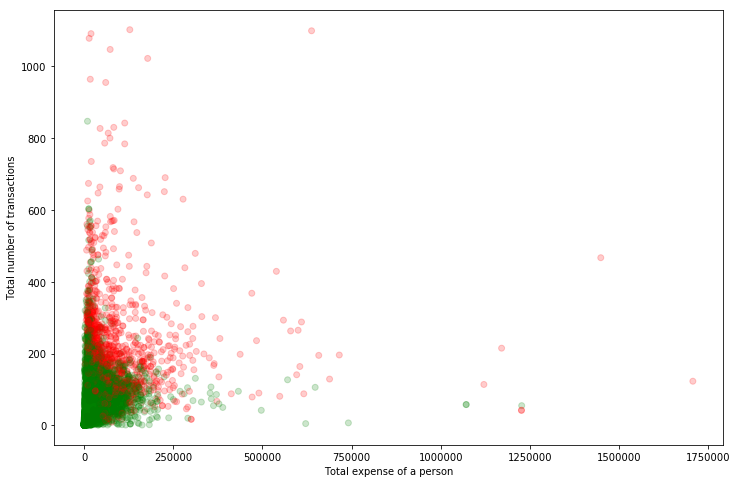

In [255]:
col = (df1['Rank'] < 0.31).replace({True : 'g', False: 'r'})
plt.figure(figsize=(12, 8))
plt.xlabel('Total expense of a person')
plt.ylabel('Total number of transactions')
plt.scatter(df1['AverageExpense'], df1['CountPerDay'], c=col, alpha=0.2)
plt.savefig('outliers.png')
plt.show()

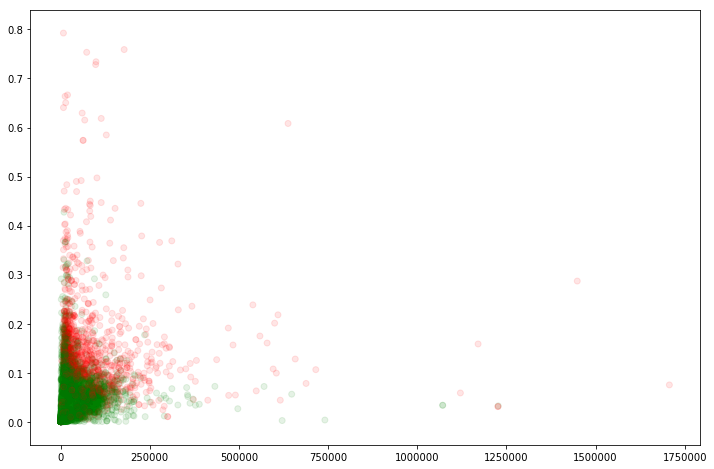

In [253]:
col = (df1['Rank'] < 0.31).replace({True : 'g', False: 'r'})
plt.figure(figsize=(12, 8))
plt.scatter(df1['AverageExpense'], df1['CountPerDay']/df1['Duration'], c=col, alpha=0.1)

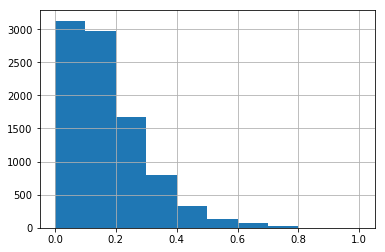

In [254]:
(df1['Rank']/df1['Rank'].max()).hist()